# Pytorch Notebook

In [170]:
from __future__ import unicode_literals, print_function, division

import os
import sys
import pprint
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pyro
import pyro.distributions as dist
import pyro.optim as optim_pyro
import pyro.contrib.examples.util

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

## Pytorch basics
If you are using jupyterlab, enable "show contextual help" for checking the definitions of functions!

In [145]:
# Get variables
x = torch.ones(3, 4)

print(x)
print(x.view(1, 12))
print(x.view(2, -1))

y = torch.rand(3, 4)
z = x + y

print(z.size())
print(z)

# Matrix product
x = torch.randn(4, 4)
v = torch.randn(1, 4)
z = torch.mm(v, x)
print(z)
z = torch.matmul(v, x)
print(z)

# Dot product
x = torch.randn(4)
v = torch.randn(4)
z = torch.dot(x, v)
print(z)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])
torch.Size([3, 4])
tensor([[1.8075, 1.1918, 1.0777, 1.3787],
        [1.8548, 1.0903, 1.9512, 1.2047],
        [1.6718, 1.4737, 1.1979, 1.5236]])
tensor([[-0.3725,  1.7241, -0.5482, -0.5179]])
tensor([[-0.3725,  1.7241, -0.5482, -0.5179]])
tensor(-2.4792)


In [3]:
# Auto grad basics
x = torch.ones(1, 2, requires_grad=True)
print(x)

y = 2 * x + 2
print(y)
print(y.grad_fn)

z = y * y * 3
out = z.mean()
print(z, out)

# , detach

tensor([[1., 1.]], requires_grad=True)
tensor([[4., 4.]], grad_fn=<AddBackward0>)
tensor([[48., 48.]], grad_fn=<MulBackward0>) tensor(48., grad_fn=<MeanBackward0>)


In [4]:
x = torch.randn(2, 2)  # <-- for constants, requires_grad is initially False
x = ((x * 3) / (x - 1))
print(x.requires_grad)

x.requires_grad_(True) # <-- Switch requires_grad by hand
print(x.requires_grad)

y = (x ** 2).sum()
print(y.grad_fn)

False
True


### backward

In [5]:
x = torch.ones(2, 2, requires_grad=True) # <-- enable grad calculation
print(x)
print(x.requires_grad)
print(x.grad_fn)
print("---")

y = x + 2
print(y)
print(y.requires_grad)
print(y.grad_fn)
print("---")

z = y * y * 3
out = z.mean()
print(z, out)
print(z.requires_grad, out.requires_grad)
print(z.grad_fn, out.grad_fn)
print("---")

out.backward() # <-- run backprop
print(x.grad)

# running backward() multiple times elicit an error
#out.backward() # <-- run backprop
#print(x.grad)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
True
None
---
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
True
---
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)
True True
<MulBackward0 object at 0x12dbbeb00> <MeanBackward0 object at 0x12dbbebe0>
---
tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


### vector-Jacobian product
This characteristic of vector-Jacobian product makes it very convenient to feed external gradients into a model that has non-scalar output.

Now in this case y is no longer a scalar. torch.autograd could not compute the full Jacobian directly, but if we just want the vector-Jacobian product, simply pass the vector to backward as argument. $J$ is jacobian. and ${\rm x\_grad} = J^\top v$. If the backward target is a scalar function, $v = (\frac{l}{y_1}, \cdots, \frac{l}{y_m})^\top$

In [6]:
x = torch.ones(3, requires_grad=True)
y = x * 2

print(f"norm : {y.data.norm()}")
print(y)
while y.data.norm() < 1000:
    y = y * 2
    print(f"norm : {y.data.norm()}")
    print(y)

v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)
print(x.grad)

norm : 3.464101552963257
tensor([2., 2., 2.], grad_fn=<MulBackward0>)
norm : 6.928203105926514
tensor([4., 4., 4.], grad_fn=<MulBackward0>)
norm : 13.856406211853027
tensor([8., 8., 8.], grad_fn=<MulBackward0>)
norm : 27.712812423706055
tensor([16., 16., 16.], grad_fn=<MulBackward0>)
norm : 55.42562484741211
tensor([32., 32., 32.], grad_fn=<MulBackward0>)
norm : 110.85124969482422
tensor([64., 64., 64.], grad_fn=<MulBackward0>)
norm : 221.70249938964844
tensor([128., 128., 128.], grad_fn=<MulBackward0>)
norm : 443.4049987792969
tensor([256., 256., 256.], grad_fn=<MulBackward0>)
norm : 886.8099975585938
tensor([512., 512., 512.], grad_fn=<MulBackward0>)
norm : 1773.6199951171875
tensor([1024., 1024., 1024.], grad_fn=<MulBackward0>)
tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


### Stop autograd by wrapping with no_grad

In [7]:
x = torch.ones(2, 2, requires_grad=True)
print(x)
print((x ** 2).requires_grad)

# stop autograd and block 
with torch.no_grad():
    print((x ** 2).requires_grad)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
True
False


### Use detach() to get a "new" Tensor with the same content but that does not require gradient

In [8]:
x = torch.tensor([2], dtype=torch.float, requires_grad=True)
y = torch.tensor([3], dtype=torch.float, requires_grad=True)

out = (x ** 2) * (y ** 2)
print(out.requires_grad)
z = out.detach()
print(z.requires_grad)

# z.backward() # <-- return an error

True
False


## Autograd and some specific topics

### Define Fully Connected Feed Forward NN $f_{\theta}$ 

In [32]:
class FFNetwork(nn.Module):
    # One input, one output, two hidden layers

    def __init__(self, n_hidden):
        super(FFNetwork, self).__init__()
        
        self.fc1 = nn.Linear(in_features=1, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
        self.fc3 = nn.Linear(in_features=n_hidden, out_features=1)
    
    def forward(self, x):
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        out = self.fc3(h)
        return out

ffnet = FFNetwork(10)
print(ffnet)

params = list(ffnet.parameters())
#print(params)
print(f"num_params : {len(params)}")
for i in range(len(params)):
    print(params[i].size())
print("---")

# Trial input
input = torch.randn(3, 1)
print(input)
out = ffnet(input) # same with ffnet.forward(input)
print(out)

FFNetwork(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=1, bias=True)
)
num_params : 6
torch.Size([10, 1])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])
torch.Size([1, 10])
torch.Size([1])
---
tensor([[-0.2820],
        [ 1.9925],
        [-1.3599]])
tensor([[ 0.0692],
        [-0.0605],
        [ 0.1300]], grad_fn=<AddmmBackward>)


### Calculate Loss $L(\theta)$

In [100]:
input = torch.randn(10, 1)
target = torch.ones(10, 1)
print(input.requires_grad)
print(target.requires_grad)

ffnet = FFNetwork(10)

# Mean squared error of the minibatch with 10 samples
loss_func = nn.MSELoss()

out = ffnet(input)
loss = loss_func(out, target)
print(loss)

False
False
tensor(1.0311, grad_fn=<MseLossBackward>)


### Calculate $\nabla_\theta L(\theta, x)|_{x=x_0}$

In [101]:
input = torch.randn(10, 1)
target = torch.ones(10, 1)

ffnet = FFNetwork(10)

out = ffnet(input)
loss_func = nn.MSELoss()
loss = loss_func(out, target)

ffnet.zero_grad()
print("ffnet.fc1.[param].grad before backward")
print(ffnet.fc1.bias.grad)
print(ffnet.fc1.weight.grad)
print("---")

loss.backward()
print("ffnet.fc1.[param].grad after backward")
print(ffnet.fc1.bias.grad)
print(ffnet.fc1.weight.grad)

ffnet.fc1.[param].grad before backward
None
None
---
ffnet.fc1.[param].grad after backward
tensor([ 1.9350e-02, -1.6908e-01,  1.3575e-02, -9.5872e-05,  9.6607e-05,
        -2.0997e-01,  2.9409e-01,  2.8184e-02,  5.8546e-02,  5.0708e-04])
tensor([[-0.0449],
        [ 0.0268],
        [-0.0186],
        [ 0.0003],
        [ 0.0008],
        [-0.2010],
        [ 0.1400],
        [ 0.0351],
        [ 0.0057],
        [ 0.0042]])


### Update $\theta \leftarrow \theta + \alpha \nabla_\theta L(\theta, x)|_{x=x_0}$

#### Individual parameter update

tensor([[0.9231],
        [0.9233],
        [1.3031],
        [0.8204],
        [0.9104],
        [0.9550],
        [0.8514],
        [0.9461],
        [1.0208],
        [0.8067]])


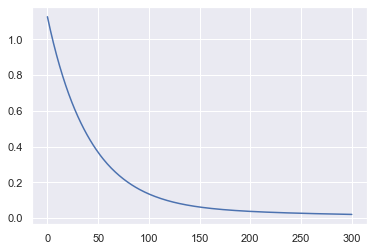

In [102]:
input = torch.randn(10, 1)
target = torch.ones(10, 1)

ffnet = FFNetwork(n_hidden=50)
learning_rate = 0.001

out = ffnet(input)
loss_func = nn.MSELoss()
loss = loss_func(out, target)

loss_hist_sgd = [loss.detach()]
for i in range(300):
    ffnet.zero_grad()
    loss.backward()
    for f in ffnet.parameters():
        f.data.sub_(f.grad.data * learning_rate)
        
    loss = loss_func(ffnet(input), target)
    loss_hist_sgd.append(loss.detach())

plt.plot(loss_hist_sgd)
out = ffnet.forward(input)
print(out.detach())

#### Update by using Optimizer

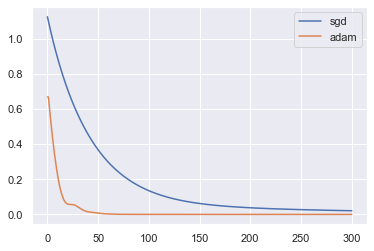

In [103]:
input = torch.randn(10, 1)
target = torch.ones(10, 1)

ffnet = FFNetwork(50)
learning_rate = 0.001

optimizer = optim.Adam(ffnet.parameters(), lr=learning_rate)

loss_func = nn.MSELoss()
loss = loss_func(ffnet(input), target)
loss_hist_adam = [loss.detach()]

for i in range(300):
    optimizer.zero_grad()
    loss = loss_func(ffnet(input), target)
    loss_hist_adam.append(loss.detach())
    loss.backward()
    optimizer.step()

plt.plot(loss_hist_sgd, label="sgd")
plt.plot(loss_hist_adam, label="adam")
plt.legend(loc="best")

### Update weight by minibatch $\frac{1}{N} \sum_{n=1}^N \nabla_\theta L(\theta, x)|_{x=x_n}$

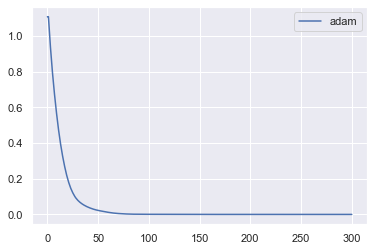

In [34]:
n = 50
input = torch.randn(n, 1)
target = torch.ones(n, 1)

ffnet = FFNetwork(50)
learning_rate = 0.001

optimizer = optim.Adam(ffnet.parameters(), lr=learning_rate)

loss_func = nn.MSELoss()
loss = loss_func(ffnet.forward(input), target)
loss_hist_adam = [loss.detach()]

for i in range(300):
    optimizer.zero_grad()
    loss = loss_func(ffnet.forward(input), target)
    loss_hist_adam.append(loss.detach())
    loss.backward()
    optimizer.step()

plt.plot(loss_hist_adam, label="adam")
plt.legend(loc="best")

#### Network Saving Options

In [41]:
# SavingFFNetworkget
ffnet = FFNetwork(10)

# Path
PATH = "./saved_network"
try:
    os.makedirs(PATH)
except OSError:
    pass
PATH = os.path.join(PATH, "fnet.pth")

# SAVE (RECOMMANDED)
torch.save(ffnet.state_dict(), PATH)
print("Saved.")

# LOAD
ffnet_loaded = FFNetwork(10)
ffnet_loaded.load_state_dict(torch.load(PATH))
print("Loaded.")

# # SAVE ENTIRE model
# torch.save(ffnet, PATH)

# # LOAD ENTIRE model
# ffnet_loaded = FFNetwork()
# ffnet_loaded.load_state_dict(PATH)


Saved.
Loaded.


### Calculate $\nabla_x L(\theta, x)|_{x=x_0}$

In [105]:
input = torch.zeros(1, requires_grad=True)
input_0 = torch.zeros_like(input, requires_grad=False)
target = torch.ones(1)

ffnet = FFNetwork(50)
learning_rate = 0.1

optimizer = optim.Adam([input], lr=learning_rate)
# Update with network parameters
#optimizer = optim.Adam([input] + [w for w in ffnet.parameters()], lr=learning_rate)

loss_func = nn.MSELoss()
y = ffnet(input)
optimizer.zero_grad()

sum_w = 0
for w in ffnet.parameters():
    sum_w += torch.sum(torch.abs(w))

loss = loss_func(y, target)
loss.backward()
optimizer.step()

print("weight gradient ---")
for w in ffnet.parameters():
    sum_w -= torch.sum(torch.abs(w))
print(f"Absolute difference of weight from initial weights : {sum_w}")
print("input gradient ----- ")
print(input.grad)
print(input - input_0)

weight gradient ---
Absolute difference of weight from initial weights : -1.2874603271484375e-05
input gradient ----- 
tensor([-0.0041])
tensor([0.1000], grad_fn=<SubBackward0>)


### Update $x \leftarrow x + \alpha \nabla_x L(\theta, x)|_x$

weight gradient ---
Absolute difference of weight from initial weights : -6.541609764099121e-06
input gradient ----- 
tensor([0.])
tensor([-3.5146], grad_fn=<SubBackward0>)


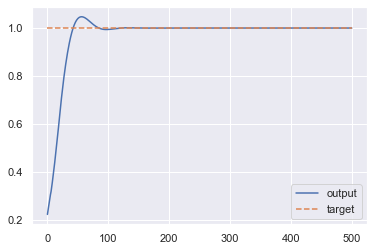

In [125]:
input = torch.zeros(1, requires_grad=True)
target = torch.ones(1)

ffnet = FFNetwork(50)
learning_rate = 0.1

optimizer = optim.Adam([input], lr=learning_rate)
# Update with network parameters
#optimizer = optim.Adam([input] + [w for w in ffnet.parameters()], lr=learning_rate)

loss_func = nn.MSELoss()
y = ffnet(input)
hist_adam = [y.detach()]

sum_w = 0
for w in ffnet.parameters():
    sum_w -= torch.sum(torch.abs(w))

# Update Rule
for i in range(500):
    optimizer.zero_grad()
    loss = loss_func(y, target)
    loss.backward()
    optimizer.step()
    y = ffnet(input)
    hist_adam.append(y.detach())

plt.plot(hist_adam, label="output")
plt.plot([1.0]*len(hist_adam), "--", label="target")
plt.legend(loc="best")

print("weight gradient ---")
for w in ffnet.parameters():
    sum_w += torch.sum(torch.abs(w))
print(f"Absolute difference of weight from initial weights : {sum_w}")
print("input gradient ----- ")
print(input.grad)
print(input - input_0)

### Copy $\theta_1$ to $\theta_2$

In [96]:
n = 50
learning_rate = 0.001

input = torch.randn(n, 1)
target = torch.ones(n, 1)
ffnet1 = FFNetwork(50)

# Copy Network
ffnet2 = FFNetwork(50)
ffnet2.load_state_dict(ffnet1.state_dict())

<All keys matched successfully>

### Copy $\theta_1$ to $\theta_2$ and update only $\theta_1$ by $\theta \leftarrow \theta + \alpha \nabla_\theta L(\theta, x)|_{x=x_0}$

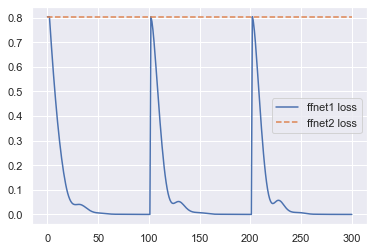

In [97]:
n = 50
learning_rate = 0.001

input = torch.randn(n, 1)
target = torch.ones(n, 1)
ffnet1 = FFNetwork(50)

# Copy Network
ffnet2 = FFNetwork(50)
ffnet2.load_state_dict(ffnet1.state_dict())

optimizer = optim.Adam(ffnet1.parameters(), lr=learning_rate)

loss_func = nn.MSELoss()
loss1 = loss_func(ffnet1(input), target)
loss1_hist_adam = [loss1.detach()]
loss2 = loss_func(ffnet2(input), target)
loss2_hist_adam = [loss2.detach()]

for i in range(300):
    optimizer.zero_grad()
    
    loss1 = loss_func(ffnet1(input), target)
    loss1_hist_adam.append(loss1.detach())
    loss2 = loss_func(ffnet2(input), target)
    loss2_hist_adam.append(loss2.detach())
    
    loss1.backward()
    optimizer.step()
    
    # Copy 2nd Nework Parameters into 1st Network every 100 steps
    if i % 100 == 0:
        ffnet1.load_state_dict(ffnet2.state_dict())

plt.plot(loss1_hist_adam, label="ffnet1 loss")
plt.plot(loss2_hist_adam, "--", label="ffnet2 loss")
plt.legend(loc="best")

### Stochastic sampling from $f_\theta(x)$

(-1.0, 1.0)

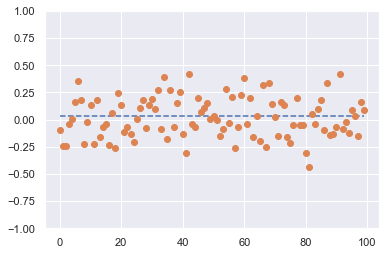

In [165]:
n = 1
learning_rate = 0.001

input = torch.randn(n, 1)
target = torch.ones(n, 1)
ffnet = FFNetwork(50)

mu = ffnet(input)
sigma = 0.2

sample_list = []
for i in range(100):
    sample = mu + sigma * torch.randn_like(mu)
    sample_list.append(sample.detach()[0])

plt.plot([mu.detach()[0]] * 100, "--", label="mean")
plt.plot(sample_list, "o", label="samples")
plt.ylim([-1, 1])

### Inject noise (reparametrization trick) and cal grad $\nabla_\theta f_\theta(x, \epsilon)$, $\epsilon\sim {\cal N}(\mu, \sigma^2)$

In [130]:
class ProbabilisticFFNetwork(nn.Module):
    # One input, one output, two hidden layers

    def __init__(self, n_hidden):
        super(ProbabilisticFFNetwork, self).__init__()
        
        self.fc1 = nn.Linear(in_features=1, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
        self.fc3_mean = nn.Linear(in_features=n_hidden, out_features=1)
        self.fc3_std = nn.Linear(in_features=n_hidden, out_features=1)
    
    def forward(self, x):
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        mean = self.fc3_mean(h)
        std = self.fc3_std(h)
        return mean, std
    
    def sample(self, x):
        mu, std = self.forward(x)
        return mu + std * torch.randn_like(mu)

n = 1
learning_rate = 0.001

# Target distribution
target_mu = 1.0
target_std = 1.0

input = torch.randn(n, 1)
target = torch.ones(n, 1)
ffnet = ProbabilisticFFNetwork(50)

f = ffnet.sample(input)

optimizer = optim.Adam(ffnet.parameters(), lr=learning_rate)
optimizer.zero_grad()

f.backward()

sum_grad_w = 0
for w in ffnet.parameters():
    sum_grad_w += torch.sum(torch.abs(w.grad))
    
print(f" sum_grad_abs : {sum_grad_w}")

 sum_grad_abs : 49.45521926879883


### Use weighted update $\theta \leftarrow \theta + \alpha \delta \nabla_\theta L(\theta, x)|_{x=x_0}$, $\delta  = f_\theta(x) - \theta_0$

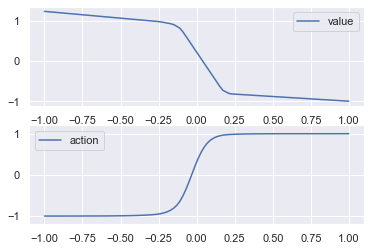

In [294]:
class ProbabilisticFFNetwork(nn.Module):
    # One input, one output, two hidden layers

    def __init__(self, n_hidden):
        super(ProbabilisticFFNetwork, self).__init__()
        
        self.fc1 = nn.Linear(in_features=1, out_features=n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden, out_features=n_hidden)
        self.fc3 = nn.Linear(in_features=n_hidden, out_features=1)
    
    def forward(self, x):
        h = F.leaky_relu(self.fc1(x))
        h = F.leaky_relu(self.fc2(h))
        mean = torch.tanh(self.fc3(h))
        return mean
    
    def sample(self, x):
        mu = self.forward(x)
        return mu + 0.2*torch.randn_like(mu)


value_net = FFNetwork(100)
policy_net = ProbabilisticFFNetwork(200)

optimizer_value = optim.Adam(value_net.parameters(), lr=0.01, eps=0.1, weight_decay=0.01)
optimizer_policy = optim.Adam(policy_net.parameters(), lr=0.001, eps=0.1, weight_decay=0.01)

for i in range(3000):
    # Environment: contextual bandit
    obs = 2.0 * (torch.rand(1) - 0.5)
    action = policy_net.sample(input).detach()
    if obs > 0:
        if action[0] >= 0:
            reward = +1.0
        else:
            reward = -1.0
    else:
        if action[0] >= 0:
            reward = -1.0
        else:
            reward = +1.0
    #print(f"{obs} : {action} : {reward}")

    # Updates
    optimizer_value.zero_grad()
    optimizer_policy.zero_grad()

    # Value Update
    loss_value = torch.square(value_net(obs) - torch.tensor([reward]))
    loss_value.backward()
    optimizer_value.step()

    # Policy Update
    td_error = reward - value_net(obs)
    mean = policy_net(obs)
    loss_policy = td_error.detach() * torch.square(action - mean)
    loss_policy.backward()
    optimizer_policy.step()

x = torch.tensor([[v] for v in np.linspace(-1, 1, 100)], dtype=torch.float)
val = value_net(x).detach()
u = policy_net(x).detach()

plt.subplot(2,1,1)
plt.plot(x, val,label="value")
plt.legend(loc="best")
plt.subplot(2,1,2)
plt.plot(x, u,label="action")
plt.ylim([-1.2, 1.2])
plt.legend(loc="best")

### Use noisy weight $f(x, \theta + \epsilon)$, $\epsilon \sim {\cal N}(0, 0.001)$

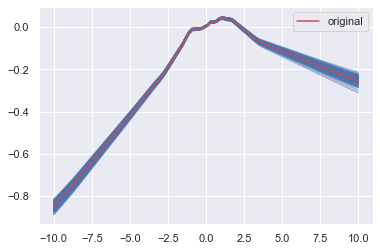

In [329]:
from collections import OrderedDict

ffnet1 = FFNetwork(50)
ffnet2 = FFNetwork(50)

x = torch.tensor([[v] for v in np.linspace(-10, 10, 100)], dtype=torch.float)
for i in range(100):
    # Weight fluctuation
    dict_new = OrderedDict(
        [(k, v + 0.001 * torch.randn_like(v)) for (k, v) in ffnet1.state_dict().items()]
    )
    ffnet2.load_state_dict(dict_new)
    # Plot
    plt.plot(x, ffnet2(x).detach(), "b", alpha=0.5)

# Plot original 
plt.plot(x, ffnet1(x).detach(), "r", label="original")
plt.legend(loc="best")

### Update $\theta$ by the approximated variational method

#### Example of the variational autoencoder with pyro https://pyro.ai/examples/vae.html

[epoch 000]  average training loss: 190.9630
[epoch 000] average test loss: 155.7649
[epoch 005]  average training loss: 115.9922
[epoch 010]  average training loss: 109.2412
[epoch 010] average test loss: 108.4224
[epoch 015]  average training loss: 106.7663
[epoch 020]  average training loss: 105.4152
[epoch 020] average test loss: 104.8534
[epoch 025]  average training loss: 104.5939


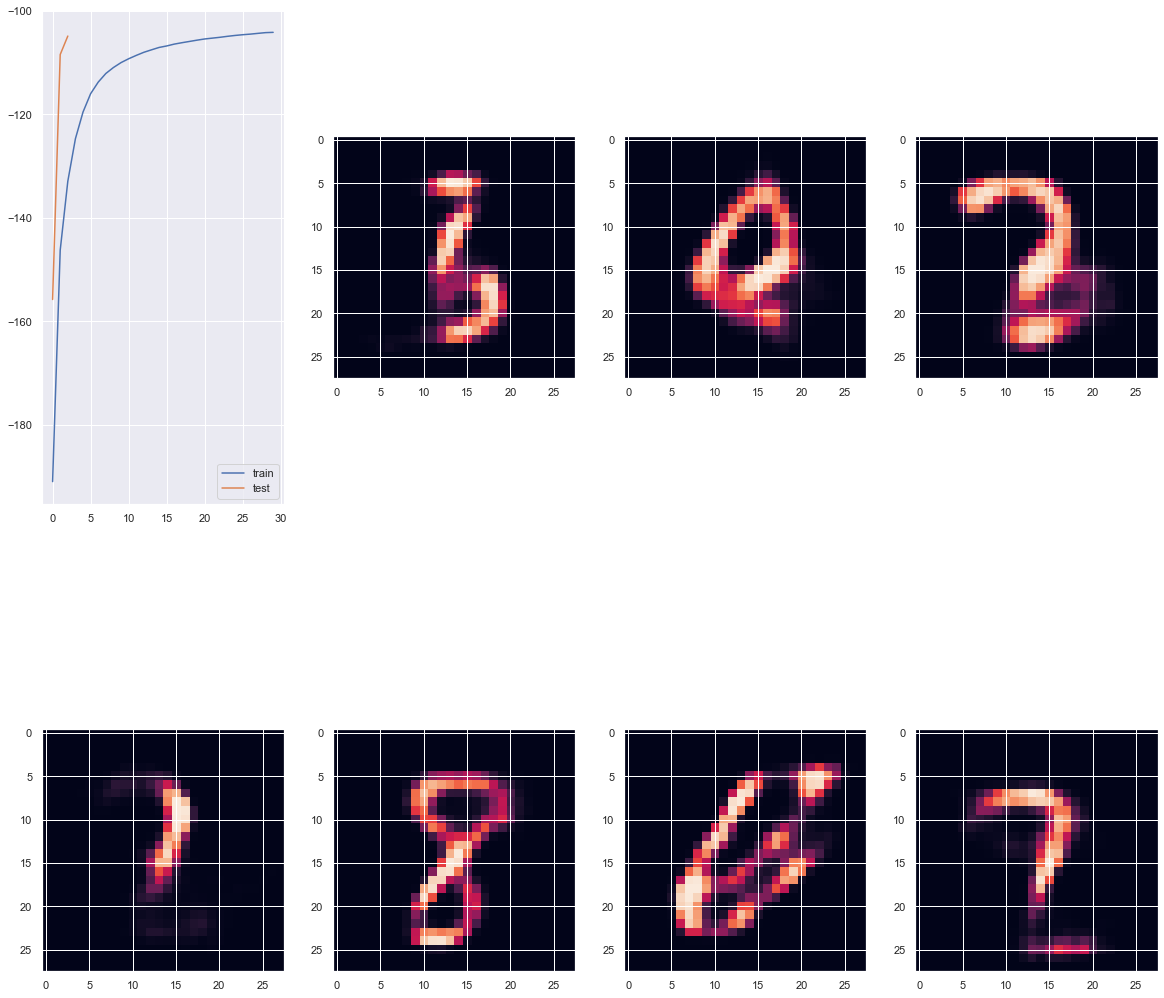

In [5]:
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img
    
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(784, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        self.softplus = nn.Softplus()

    def forward(self, x):
        x = x.reshape(-1, 784)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale
    
class VAE(nn.Module):
    def __init__(self, z_dim=50, hidden_dim=400):
        super().__init__()
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).to_event(1), obs=x.reshape(-1, 784))
            return loc_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

def train(svi, train_loader):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

def evaluate(svi, test_loader):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x, _ in test_loader:
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test


# Run options
LEARNING_RATE = 1.0e-3

# Run only for a single iteration for testing
NUM_EPOCHS = 30
TRAIN_PERFORMANCE = 5 
TEST_FREQUENCY = 10


train_loader, test_loader = setup_data_loaders(batch_size=256)

# clear param store
pyro.clear_param_store()

# setup the VAE
vae = VAE()

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = optim_pyro.Adam(adam_args)

# setup the inference algorithm
svi = pyro.infer.SVI(vae.model, vae.guide, optimizer, loss=pyro.infer.Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader)
    train_elbo.append(-total_epoch_loss_train)
    
    if epoch % TRAIN_PERFORMANCE == 0:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

plt.figure(figsize=(20, 20))
plt.subplot(2,4,1)
plt.plot(train_elbo, label="train")
plt.plot(test_elbo, label="test")
plt.legend(loc="best")

for i in range(2, 9):
    plt.subplot(2,4,i)
    sample = vae.model(torch.rand(1, 784))
    plt.imshow(sample[0].view(28, 28).detach().numpy())

#### Example of the variational autoencoder without pyro

# Convolution Neural Networks

Files already downloaded and verified
Files already downloaded and verified


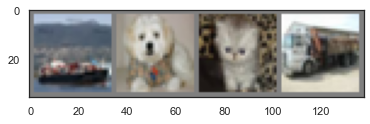

 ship   dog   cat truck
label: tensor([8, 5, 3, 9])


In [52]:
# for loading and batching CIFER10 dataset
def setup_data_loaders(batch_size=4):
    root = './data'
    download = True
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    num_workers = 2
    
    # Training Data
    train_set = dset.CIFAR10(root=root, train=True, download=download, transform=trans)
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    # Test Data
    test_set = dset.CIFAR10(root=root, train=False, download=download, transform=trans)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # Class
    classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    return train_loader, test_loader, classes

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # shift color channel
    plt.show()

    
train_loader, test_loader, classes = setup_data_loaders()

# Get random images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
sns.set_style("white")
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# show labels of images
print(f"label: {labels}")

### Define CNN $f_\theta(x)$

In [53]:
class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # conv 3 channels to 6 feat. maps.
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # conv 6 feat. maps to 16 feat. maps
        self.f1 = nn.Linear(16 * 5 * 5, 120) # 16 feat. maps with 5x5 size
        self.f2 = nn.Linear(120, 84)
        self.f3 = nn.Linear(84, 10)
        
    
    def forward(self, x: torch.Tensor):
        h = self.pool(F.leaky_relu(self.conv1(x)))
        h = self.pool(F.leaky_relu(self.conv2(h)))
        h = h.view(-1, 16 * 5 * 5)
        h = F.leaky_relu(self.f1(h))
        h = F.leaky_relu(self.f2(h))
        out = F.leaky_relu(self.f3(h))
        return out
    
    def predict(self, x: torch.Tensor):
        outputs = self.forward(x)
        _, predicted = torch.max(outputs, 1)  # Return maximum of P(class|data)
        return predicted

### Update weight by minibatch for CNN

Start Training...
[1, 6000] loss: 1.7098984401896595
[1, 12000] loss: 1.4275310163199901
[2, 6000] loss: 1.2912800361141563
[2, 12000] loss: 1.263686627082837
[3, 6000] loss: 1.1497332352216667
[3, 12000] loss: 1.1588063219084095
[4, 6000] loss: 1.081411269830792
[4, 12000] loss: 1.0842889217389748
[5, 6000] loss: 1.0095293432114025
[5, 12000] loss: 1.03019873938011
[6, 6000] loss: 0.9575385041887251
[6, 12000] loss: 0.9830515868506239
[7, 6000] loss: 0.9115646569938205
[7, 12000] loss: 0.9536277854006427
[8, 6000] loss: 0.884356406633684
[8, 12000] loss: 0.9234327273218951
[9, 6000] loss: 0.8660586310986934
[9, 12000] loss: 0.8902556134406471
[10, 6000] loss: 0.8231758782693457
[10, 12000] loss: 0.8728065443034866
Finish Training


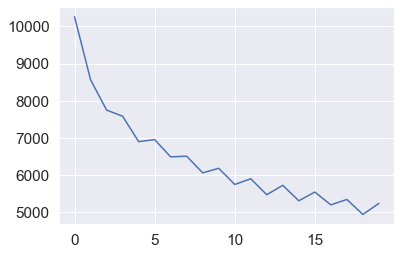

In [116]:
cnnet = CNNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnnet.parameters(), lr=0.001)

REPORT_EVERY = 6000.
NUM_EPOCH = 10

loss_history = []
print("Start Training...")
for epoch in range(NUM_EPOCH):
    running_loss = 0.
    for i, data in enumerate(train_loader, 0):
        imgs, labels = data
        
        optimizer.zero_grad()
        
        outputs = cnnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % REPORT_EVERY == (REPORT_EVERY - 1):
            print(f"[{epoch + 1}, {i+1}] loss: {running_loss/REPORT_EVERY}")
            loss_history.append(running_loss)
            running_loss = 0.

sns.set_style("darkgrid")
plt.plot(loss_history)

print("Finish Training")

In [117]:
# Path
PATH = "./saved_network"
try:
    os.makedirs(PATH)
except OSError:
    pass
PATH = os.path.join(PATH, "cnnet.pth")

# SAVE (RECOMMANDED)
torch.save(cnnet.state_dict(), PATH)
print("Saved.")

Saved.


#### Test Performance

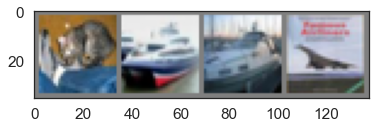

Ground Truth:  cat  ship  ship plane
Predicted:  cat plane   car plane
Accuracy of plane: 75.8
Accuracy of car: 80.2
Accuracy of bird: 38.2
Accuracy of cat: 35.8
Accuracy of deer: 60.4
Accuracy of dog: 60.3
Accuracy of frog: 69.9
Accuracy of horse: 69.9
Accuracy of ship: 67.6
Accuracy of truck: 65.6
--- Confusion Matrix
[[758  31  47  13  24  14   5  19  64  25]
 [ 38 802   4   5  11  10   8  12  28  82]
 [105   7 382  57 161 119  76  58  17  18]
 [ 38  20  48 358 102 258  70  50  34  22]
 [ 39   8  53  38 604  58  66 107  19   8]
 [ 24   4  26 136  77 603  23  73  12  22]
 [ 12  10  36  52  90  67 699  12  10  12]
 [ 30   4  20  36  66 107  10 699   5  23]
 [171  64   6  13  13  16  11  10 676  20]
 [ 81 134   4  22  11  12  15  23  42 656]]


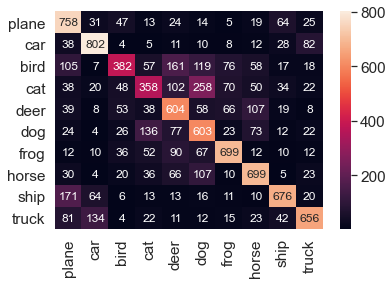

In [118]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
sns.set_style("white")
imshow(torchvision.utils.make_grid(images))
print("Ground Truth:" + ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# load network
cnnet = CNNet()
cnnet.load_state_dict(torch.load("./saved_network/cnnet.pth"))

# predict
predicted = cnnet.predict(images)
print("Predicted:" + " ".join('%5s' % classes[predicted[j]] for j in range(4)))


# Test total test data
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
confusion_matrix = np.zeros((len(classes), len(classes)), dtype=np.int)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        predicted = cnnet.predict(images)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            confusion_matrix[label][predicted[i]] += 1

for i in range(len(classes)):
    print(f"Accuracy of {classes[i]}: {100. * class_correct[i]/class_total[i]}")

print("--- Confusion Matrix")
print(confusion_matrix)

df_cm = pd.DataFrame(confusion_matrix,
                    classes, classes)
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt="g")

### Update $x \leftarrow x + \alpha \nabla_x L(\theta, x)|_x$ for CNNheatmap

tensor([0])


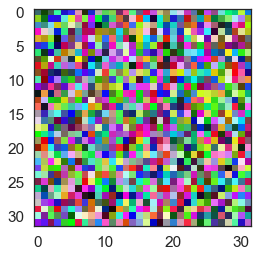

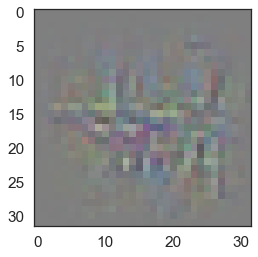

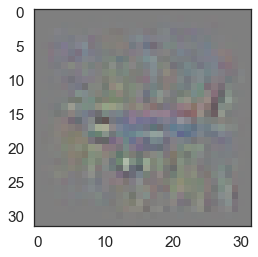

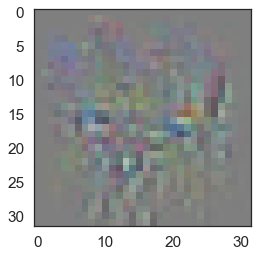

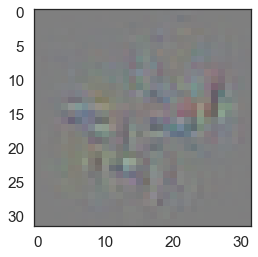

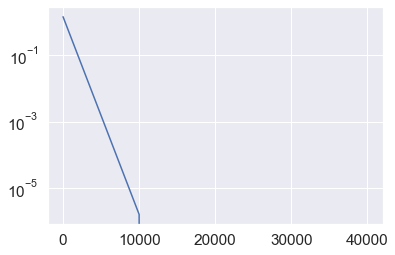

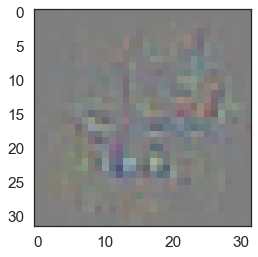

In [147]:
# load network
cnnet = CNNet()
cnnet.load_state_dict(torch.load("./saved_network/cnnet.pth"))

# image
a = (torch.randn((1, 3, 32, 32))).requires_grad_(True)
image = F.tanh(a)
sns.set_style("white")

def gen_img(x):
    x_ = ((x[0].detach() + 1)/2.).detach().numpy()  # [-1, 1] --> [0, 1]
    x_ = np.transpose(x_, (1, 2, 0))
    plt.imshow(x_)
    plt.show()

target = torch.tensor([0])
# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(target)

learning_rate = 0.01
optimizer = optim.Adam([a], lr=learning_rate, weight_decay=0.00001)

criterion = nn.CrossEntropyLoss()
y = cnnet(F.tanh(a))
loss_hist = {"iter": [], "loss":[]}

# Update Rule
for i in range(50000):
    optimizer.zero_grad()
    loss = criterion(y, target)
    loss.backward()
    optimizer.step()
    y = cnnet(F.tanh(a + 0.1*torch.randn((1, 3, 32, 32))))
    if i % 10000 == 0:
        loss_hist["iter"].append(i)
        loss_hist["loss"].append(loss.item())
        image = F.tanh(a)
        gen_img(image)

sns.set_style("darkgrid")
plt.plot(loss_hist["iter"], loss_hist["loss"])
plt.yscale("log")
plt.show()

sns.set_style("white")
image = F.tanh(a)
gen_img(image)

# Recurrent Neural Networks

Reference: [NLP FROM SCRATCH: CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN]
Save this [data of names](https://download.pytorch.org/tutorial/data.zip) into "data" directory.
(https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
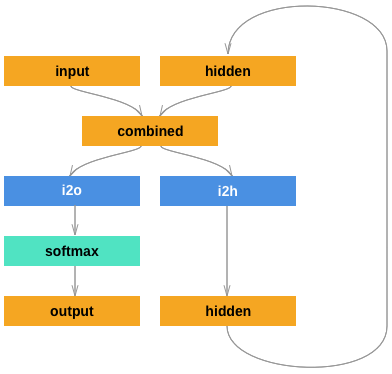

#### Data Preparation

In [171]:
import glob
import unicodedata
import string

from io import open

# name data
def findFiles(path): return glob.glob(path)
print(findFiles("data/name_data/names/*.txt"))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain Ascii.
def unicode2ascii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
        and c in all_letters
    )

print(unicode2Ascii('Ślusàrski'))

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding="utf-8").read().split("\n")
    return [unicode2ascii(line) for line in lines]

for filename in findFiles("data/name_data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)
print(category_lines.keys())

print(category_lines["Italian"][:5])
print(category_lines["English"][:5])
print(category_lines["Japanese"][:5])

['data/name_data/names/Czech.txt', 'data/name_data/names/German.txt', 'data/name_data/names/Arabic.txt', 'data/name_data/names/Japanese.txt', 'data/name_data/names/Chinese.txt', 'data/name_data/names/Vietnamese.txt', 'data/name_data/names/Russian.txt', 'data/name_data/names/French.txt', 'data/name_data/names/Irish.txt', 'data/name_data/names/English.txt', 'data/name_data/names/Spanish.txt', 'data/name_data/names/Greek.txt', 'data/name_data/names/Italian.txt', 'data/name_data/names/Portuguese.txt', 'data/name_data/names/Scottish.txt', 'data/name_data/names/Dutch.txt', 'data/name_data/names/Korean.txt', 'data/name_data/names/Polish.txt']
Slusarski
dict_keys(['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish'])
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']
['Abe', 'Abukara', 'Adachi

#### Turning Data into Tensors

In [173]:
def letter2index(letter):
    return all_letters.find(letter)

def letter2tensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letter2index(letter)] = 1
    return tensor

def line2tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letter2index(letter)] = 1
    return tensor

print(letter2tensor("J"))
print(line2tensor("Yoshida").size())


def random_choice(data):
    return data[random.randint(0, len(data) - 1)]

def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)])
    line_tensor = line2tensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print(f"category = {category} / line = {line}")

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([7, 1, 57])
category = Russian / line = Batsyn
category = Japanese / line = Eguchi
category = Greek / line = Close
category = English / line = Rashid
category = Dutch / line = Philips
category = Italian / line = Caruso
category = Scottish / line = Miller
category = Portuguese / line = Maria
category = Arabic / line = Safar
category = Czech / line = Cerney


### Define RNN $f_\theta(x_0, x_1, \dots, x_T)$

In [169]:
class RNNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNet, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.input_to_hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.input_to_output = nn.Linear(input_size + hidden_size, output_size)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.input_to_hidden(combined)
        output = self.input_to_output(combined)
        output = F.log_softmax(output, dim=1)
        return output, hidden
    
    def init_hiddden(self):
        return torch.zeros(1, self.hidden_size)
    
def category_from_output(outpur: torch.Tensor):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# Testing RNN
n_hidden = 128
rnnet = RNNet(input_size=n_letters,
            hidden_size=n_hidden,
            output_size=n_categories)

input = line2tensor("Shintani")
hidden = torch.zeros(1, n_hidden)

output, _ = rnnet(input[0], hidden)
print(output)
print(category_from_output(output))

tensor([[-2.8681, -2.9070, -2.8913, -2.9370, -2.8878, -2.9287, -3.0029, -2.8108,
         -2.7837, -2.9109, -2.9244, -2.8427, -2.8043, -2.8750, -2.9793, -2.8438,
         -2.9827, -2.8788]], grad_fn=<LogSoftmaxBackward>)
('Irish', 8)


### Update weight by minibatch for RNN

torch.Size([1, 3, 32, 32])

### Update $x \leftarrow x + \alpha \nabla_x L(\theta, x)|_x$ for RNN